In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

bank = pd.read_csv("BankChurners.csv")

#bank.info() # No missing values
bank.head()
# Removing the first and the last two columns as they will not be useful in any way
bank.drop(columns=bank.columns[-2:],inplace=True)
bank.drop('CLIENTNUM' , axis=1, inplace=True)

bank.describe(include='all')





,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,10127,10127.000000,10127,10127.000000,10127,10127,10127,10127,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
unique,2,NaN,2,NaN,7,4,6,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Existing Customer,NaN,F,NaN,Graduate,Married,Less than $40K,Blue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,8500,NaN,5358,NaN,3128,4687,3561,9436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,46.325960,NaN,2.346203,NaN,NaN,NaN,NaN,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,NaN,8.016814,NaN,1.298908,NaN,NaN,NaN,NaN,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,NaN,26.000000,NaN,0.000000,NaN,NaN,NaN,NaN,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,NaN,41.000000,NaN,1.000000,NaN,NaN,NaN,NaN,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,NaN,46.000000,NaN,2.000000,NaN,NaN,NaN,NaN,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,NaN,52.000000,NaN,3.000000,NaN,NaN,NaN,NaN,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000


<AxesSubplot:xlabel='Attrition_Flag'>

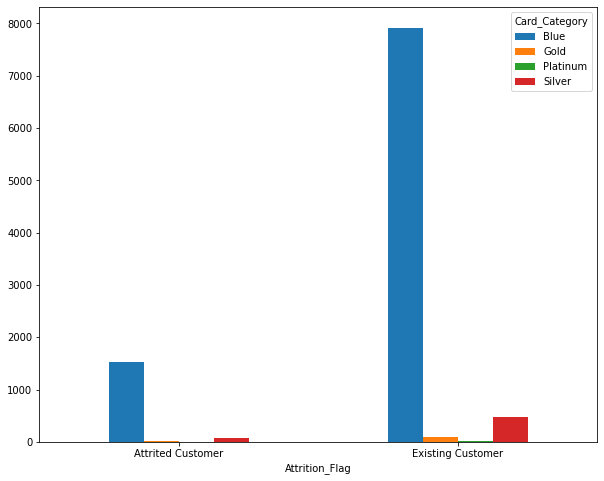

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,8))

bank.pipe(lambda df_: pd.crosstab(df_.Attrition_Flag, df_.Card_Category)).plot.bar(ax=ax, rot=0) 
# Mainly people with blue cards leave. This makes sense as this is the most common type of card.



<AxesSubplot:xlabel='Attrition_Flag'>

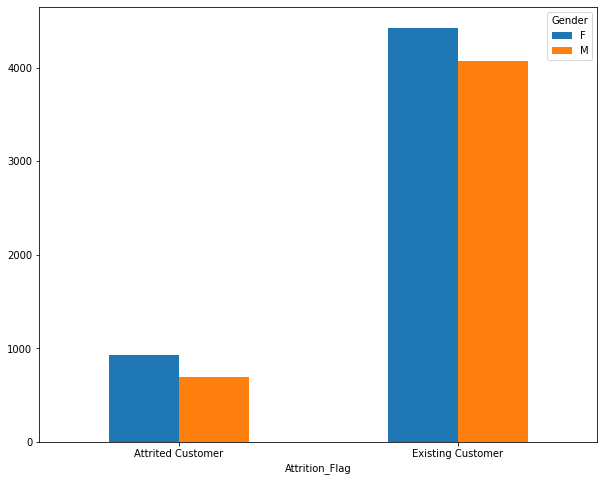

In [10]:
fig, ax = plt.subplots(figsize=(10,8))

bank.pipe(lambda df_: pd.crosstab(df_.Attrition_Flag, df_.Gender)).plot.bar(ax=ax, rot=0)

# Gender doesn't seem to make any significant difference.

In [13]:
#Model Selection


# Converting the categorical data into numerical data

bank['Attrition_Flag'] = np.where(bank['Attrition_Flag'] == 'Attrited Customer', 1,0)
bank['Gender'] = np.where(bank['Gender'] == 'M', 1,0)

bank['Attrition_Flag'].mean()
# We have much more people who stay with the bank. Will have to take care of this imbalance.

cats = bank.select_dtypes(object).columns


for cat in cats:
    bank[cat] = pd.factorize(bank[cat])[0]
    
labels = bank['Attrition_Flag']

preds = bank.iloc[:, 1:]

preds_train,preds_test,labels_train,labels_test = train_test_split(preds,labels,test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestClassifier
rfr = RandomForestClassifier()

rfr.fit(preds_train,labels_train)


print(classification_report(labels_test, rfr.predict(preds_test)))

# The model performs very well, even though the recall for the people who leave the bank is distinctively lower 
# compared to the other scores. Let's see if we can improve this.





              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1699
           1       0.92      0.81      0.86       327

    accuracy                           0.96      2026
   macro avg       0.94      0.90      0.92      2026
weighted avg       0.96      0.96      0.96      2026



In [15]:
preds_train2,preds_test2,labels_train2,labels_test2 = train_test_split(preds,labels,test_size=0.2, random_state=42, stratify=labels)

rf = RandomForestClassifier()

rf.fit(preds_train2,labels_train2)

#print(classification_report(labels_test2, rf.predict(preds_test2)))

#Fine-tuning

from sklearn.model_selection import GridSearchCV

rfr = RandomForestClassifier(random_state=42)


param_grid = [
    {'n_estimators': [50,100,500,1000], 'n_jobs' : [-1], 'max_features': [4,5,6,7,8]  }
]

gs = GridSearchCV(rfr, param_grid, cv = 10, scoring = 'accuracy', 
                          return_train_score = True
                          )
gs = gs.fit(preds_train2, labels_train2)

clf = gs.best_estimator_
clf.fit(preds_train2, labels_train2)





Test accuracy: 0.962


In [16]:
print(classification_report(labels_test2, clf.predict(preds_test2)))

# Marginal improvement only


              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1701
           1       0.92      0.83      0.88       325

    accuracy                           0.96      2026
   macro avg       0.95      0.91      0.93      2026
weighted avg       0.96      0.96      0.96      2026



In [20]:
# Upsampling to account for the imbalanced data

from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy = 1.0, random_state=42, n_jobs=-1)

preds_res, labels_res = sm.fit_sample(preds_train2,labels_train2)

gs2 = gs.fit(preds_res, labels_res)

clf2 = gs2.best_estimator_

clf2.fit(preds_res,labels_res)

print(classification_report(labels_test2, clf2.predict(preds_test2)))
    
# Since false negatives are quite costly in this context, trading a bit of precision and accuracy 
# for recall is ok.
    



              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1701
           1       0.83      0.88      0.85       325

    accuracy                           0.95      2026
   macro avg       0.90      0.92      0.91      2026
weighted avg       0.95      0.95      0.95      2026



In [21]:
# Trying the powerful LGBM CLassifier since the dataset is quite big.

from lightgbm import LGBMClassifier
import lightgbm as lgb

lgbm = LGBMClassifier()

lgbm.fit(preds_train2, labels_train2)

print(classification_report(labels_test2, lgbm.predict(preds_test2)))



              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1701
           1       0.93      0.87      0.90       325

    accuracy                           0.97      2026
   macro avg       0.95      0.93      0.94      2026
weighted avg       0.97      0.97      0.97      2026



In [22]:
# Now let's try a model with the upsampled data

lgbm2 = LGBMClassifier()

lgbm2.fit(preds_res, labels_res)


print(classification_report(labels_test2, lgbm2.predict(preds_test2)))

# Quite impressive as we finally get .9 recall for the 1s.


              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1701
           1       0.88      0.90      0.89       325

    accuracy                           0.96      2026
   macro avg       0.93      0.94      0.93      2026
weighted avg       0.96      0.96      0.96      2026

